# Generating summarizes by making the use of sentence embeddings

In [ ]:
def return_greater_than_min_num(arr, thresh=0.5, min_num=1, fix_num_flag=True, fix_num=3):
    if fix_num_flag == True:
        idx = np.argsort(arr)[-fix_num:]  
    else:
        idx_prelim = np.where(arr>= thresh)
        if idx_prelim[0].shape[0] <= min_num:
            idx = np.argsort(arr)[-min_num:]
        else:
            idx = idx_prelim
    return sorted(idx)

def predict_summaries(Xy_doc_label, y_pred, df_text, return_all = True):
    temp = {'doc_label': Xy_doc_label.flatten(), 'y_pred': y_pred.flatten()}
    df_label_pred = pd.DataFrame(temp).groupby('doc_label').agg(list)
    df_label_pred = df_label_pred.applymap(lambda x: np.array(x))
    df_label_pred = df_label_pred.applymap(lambda arr: return_greater_than_min_num(arr)) 

    df_doc = df_text[df_label_pred.index] #Return predicted summary
    
    pred_summaries = [np.array(df_doc.iloc[j])
                      [df_label_pred.iloc[j][0]].tolist()  for j in range(len(df_label_pred))]

    pred_summaries = [summ_list if type(summ_list) == str else 
                      ' '.join(summ_list) for summ_list in pred_summaries]
    if return_all == True:
        out = df_label_pred.values, df_label_pred.index, pred_summaries
    else:
        out = pred_summaries
    return out
    

def rougeScores(pred_summaries, gold_summaries, keys=['rouge1', 'rougeL'], use_stemmer=True):
    scorer = rouge_scorer.RougeScorer(keys, use_stemmer= use_stemmer) #Cal rouge scores
    n = len(pred_summaries)
    scores = [scorer.score(pred_summaries[j], gold_summaries[j]) for j in range(n)] 
    dict_scores={}                                                            
    for key in keys:
        dict_scores.update({key: {}})
    for key in keys:
        precision_list = [scores[j][key][0] for j in range(len(scores))]
        recall_list = [scores[j][key][1] for j in range(len(scores))]
        f1_list = [scores[j][key][2] for j in range(len(scores))]
        precision = np.mean(precision_list)
        recall = np.mean(recall_list)
        f1 = np.mean(f1_list)
        dict_results = {'recall': recall, 'precision': precision, 'f1': f1}
        dict_scores[key] = dict_results
    return dict_scores

## TextRank, a graph-based model for the processing of text

In [ ]:
df_embed = xTest.loc[:,'Doc_BERT_D_0': 'Doc_BERT_D_767']
df_doc_label = pd.DataFrame(Test_doc_label, columns=['doc_label'])
df = pd.concat([df_doc_label, df_embed], axis=1)

#loop through articles (docs)
pagerank_scores_list=[]
error_list = []
doc_num = np.max(Test_doc_label) 
for j in range(doc_num+1):
    #calculate cosine similiarity matrix 
    df_doc = df [df.doc_label == j].iloc[:,2:]
    n = df_doc.shape[0]
    cos_matrix = cosine_similarity(df_doc, df_doc)
    f = np.vectorize(lambda x: 0 if x == 1 else 1)
    not_eye = f(np.eye(n,n))
    cos_matrix = cos_matrix * not_eye
    
    #Convert to nx graph
    graph = nx.from_numpy_array(cos_matrix)
    
    #Calculate sentence scores and record error docs
    try:
        scores_arr = np.array(list(nx.pagerank(graph, max_iter=500).values()))
    except:
        scores_arr = np.nan
        error_list.append(j)
   
    pagerank_scores_list.append(scores_arr)
    
pagerank_scores_arr = np.array(pagerank_scores_list)
perfData = {'pagerank_scores_arr':pagerank_scores_arr}

<ipython-input-6-91035cd957d1>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pagerank_scores_arr = np.array(pagerank_scores_list)


In [ ]:
df_tmp = test_df
df_tmp['textrank_err'] = pagerank_scores_arr[:len(df_tmp)]

#pick top3 sentence by textrank score
df_tmp['idx'] = df_tmp['textrank_err'].apply(lambda x: sorted(np.argsort(x)[-3:])).values
idx_arr = df_tmp['idx'].values

#convert list of sentences to string for each predicted summary
pred_summaries = [' '.join(np.array(test_df.text_clean.iloc[j])[idx_arr[j]].tolist())
                  for j in range(len(idx_arr))]

#convert cleaned gold summary sentence lists to string for each summary
df_gold = test_df.summary_clean
gold_summaries = [' '.join(df_gold .iloc[j]) for j in range(len(pred_summaries))]

#zip each predicted / gold summary pair together and store in another tuple
summaries_comp = tuple(zip(pred_summaries, gold_summaries))

#calculate rouge scores
scores = rougeScores(pred_summaries, gold_summaries, keys=['rouge1', 'rougeL'], use_stemmer=True)

In [ ]:
model_df = pd.DataFrame({'ModelID' : ['TR:Rouge1', 'TR:RougeL']})
res_TR = pd.DataFrame(columns=['recall' , 'precision', 'f1'])
res_TR = res_TR.append(pd.DataFrame(scores).T, ignore_index=True)
res_TR = pd.concat([model_df, res_TR],axis = 1)
res_TR

,ModelID,recall,precision,f1
0,TR:Rouge1,0.272896,0.315467,0.250868
1,TR:RougeL,0.195855,0.233583,0.182307


In [ ]:
#save to pickle file
summaryComp = {'summaries_comp_T_rank': summaries_comp}
# with open('Data/summaryComp.pickle', 'wb') as handle:                                     
#     pickle.dump(summaryComp, handle)

## Logistic Regression; default model and elastic net

### Default Model

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(xTrain, yTrain)
#Predict Model
y_pred = model.predict_proba(xTest)
    
#Convert to binary predictions
y_pred_bin = (y_pred >=0.5)*1

#Return predicted summaries
idx, doc_index, pred_summaries = predict_summaries(Test_doc_label, y_pred[:,0], test_df.text_clean)

#Match with gold summaries
df_gold = test_df.summary_clean[doc_index]
gold_summaries = [' '.join(df_gold .iloc[j]) for j in range(len(pred_summaries))]
summaries_comp = tuple(zip(pred_summaries, gold_summaries))
scores = rougeScores(pred_summaries, gold_summaries, keys=['rouge1', 'rougeL'], use_stemmer=True)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('Original Summary')
summaries_comp[0][1]

Original Summary


'Bleeding from a massive chest wound, Tejano star Selena cried, "Help me! Help me! I\'ve been shot!"and then named her killer with her dying breath. Shaken witnesses yesterday told a spellbound Houston courtroom how the blood-covered, mortally wounded 23-year-old Hispanic singing sensation burst into the lobby of the Corpus Christi Days Inn last March 31. Gasping for breath, Selena told motel workers that Yolanda Saldivar the president of her fan club shot'

In [ ]:
print('Predicted Summary by LR Default')
summaries_comp[0][0]

Predicted Summary by LR Default


'"It was covered with blood. But before Selena could hand it over, she was shot. Prosecutors say it was deliberate.'

In [ ]:
model_df = pd.DataFrame({'ModelID' : ['LR_default:Rouge1', 'LR_default:RougeL']})
res_LR_default = pd.DataFrame(columns=['recall' , 'precision', 'f1'])
res_LR_default = res_LR_default.append(pd.DataFrame(scores).T, ignore_index=True)
res_LR_default = pd.concat([model_df, res_LR_default],axis = 1)
res_LR_default

,ModelID,recall,precision,f1
0,LR_default:Rouge1,0.494643,0.708379,0.514864
1,LR_default:RougeL,0.469454,0.671882,0.489722


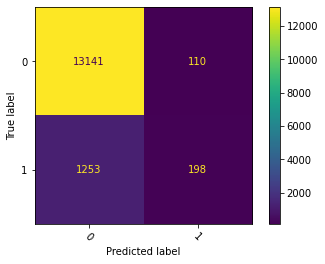

In [ ]:
# Print and visualize the results:
cm = confusion_matrix(yTest, y_pred_bin[:,1], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['0','1'])
disp.plot(xticks_rotation=-45)
plt.show()

In [ ]:
#Update sumarry dictionary and save to pickle file
summaryComp.update({'summaries_comp_LR_default': summaries_comp})
# with open('Data/summaryComp.pickle', 'wb') as handle:                                     
#     pickle.dump(summaryComp, handle)

## LR with Elastic Net Hyperparameter Tuning

**FOlowwing cell takes very long time to complete**

In [ ]:
# Do not run this cell for results generation
# Define search spaces 
L1_ratio = [0.25, 0.5, 0.75, 1] #L1-space
C_values = [0.25, 0.5, 1, 2, 4] #C-space

Rouge1_f1 = []
Params = []

for l1 in L1_ratio:
    for C in C_values:
        model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=l1, C=C, random_state=42)
        model.fit(xTrain,yTrain) #Train model
        y_pred = model.predict_proba(xTest)
        
        y_pred_bin = (y_pred >=0.5)*1 #binary predictions
        
        #Return predicted summaries
        idx, doc_index, pred_summaries = predict_summaries(Test_doc_label, y_pred[:,0], test_df.text_clean)

        #Match with gold summaries
        df_gold = test_df.summary_clean[doc_index]
        gold_summaries = [' '.join(df_gold .iloc[j]) for j in range(len(pred_summaries))]
        summaries_comp = tuple(zip(pred_summaries, gold_summaries))

        scores = rougeScores(pred_summaries, gold_summaries, keys=['rouge1', 'rougeL'], use_stemmer=True)
        f1 = scores['rouge1']['f1']
        Rouge1_f1.append(f1)
        
        params = (l1, C)
        Params.append(params)
results_dictLR_tuning = {'params': Params, 'scores': Rouge1_f1}

### **Save the hyperparameter tunning results in data table format.**
results_LR_tuning = pd.DataFrame(results_dictLR_tuning).sort_values('scores', ascending=False)
results_LR_tuning.to_csv('Data/resultLR_hypParaResults.csv')
results_LR_tuning.head(5)

**Based on above sorted score, the best parameter for the Logistic regression are L1_ratio = 1 and C = 0.25**

**LogisticRegression with saga solver as implemented in the next cell takes long time**

In [ ]:
# Best Model: Using the best parameter results
model = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=1, C=0.25, random_state=42)
model.fit(xTrain, yTrain)
#Predict Model
y_pred = model.predict_proba(xTest)
    
#Convert to binary predictions
y_pred_bin = (y_pred >=0.5)*1

#Return predicted summaries
idx, doc_index, pred_summaries = predict_summaries(Test_doc_label, y_pred[:,0], test_df.text_clean)

#Match with gold summaries
df_gold = test_df.summary_clean[doc_index]
gold_summaries = [' '.join(df_gold .iloc[j]) for j in range(len(pred_summaries))]
summaries_comp_best = tuple(zip(pred_summaries, gold_summaries))
scores = rougeScores(pred_summaries, gold_summaries, keys=['rouge1', 'rougeL'], use_stemmer=True)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
model_df = pd.DataFrame({'ModelID' : ['LR_elasticNet:Rouge1', 'LR_elasticNet:RougeL']})
res_LR_elasticNet = pd.DataFrame(columns=['recall' , 'precision', 'f1'])
res_LR_elasticNet = res_LR_elasticNet.append(pd.DataFrame(scores).T, ignore_index=True)
res_LR_elasticNet = pd.concat([model_df, res_LR_elasticNet],axis = 1)
res_LR_elasticNet

,ModelID,recall,precision,f1
0,LR_elasticNet:Rouge1,0.508569,0.727348,0.532209
1,LR_elasticNet:RougeL,0.485610,0.693151,0.508884


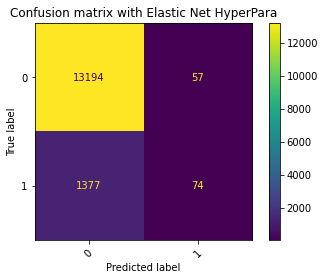

In [ ]:
cm = confusion_matrix(yTest, y_pred_bin[:,1], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['0','1'])
disp.plot(xticks_rotation=45)
plt.title('Confusion matrix with Elastic Net HyperPara')
plt.show()

In [ ]:
#Update sumarry dictionary and save to pickle file
summaryComp.update({'summaries_comp_LR_withElasticNet': summaries_comp_best})
# with open('Data/summaryComp.pickle', 'wb') as handle:                                     
#     pickle.dump(summaryComp, handle)

In [ ]:
print('Predicted Summary by LR Elastic Net')
summaries_comp_best[0][0]

Predicted Summary by LR Elastic Net


'"It was covered with blood. But before Selena could hand it over, she was shot. Prosecutors say it was deliberate.'

## Neural Nets

**Model after training in four cases has been saved. So, no need to run the training of neural net**

In [ ]:
#class_weights for imbalanced data
pos_w = int(len(yTrain) / sum(yTrain==1))
weight_dict = {0:1, 1: pos_w/2}
init = tf.keras.initializers.HeNormal(seed = 1) # weight initializer
   
#Define Model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model = Sequential([
          Dense(16, activation="relu", kernel_initializer=init),
          # Dense(8, activation="relu", kernel_initializer=init),    
          # Dense(16, activation="relu", kernel_initializer=init),
          Dense(1, activation="sigmoid", kernel_initializer=init)
        ])
# Compile the model
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])
metrics=[SensitivityAtSpecificity(0.5, num_thresholds=1), SpecificityAtSensitivity(0.5, num_thresholds=1)]

#Train Model
history = model.fit(xTrain, yTrain, epochs=50, batch_size=32, callbacks=[callback], class_weight=weight_dict)

Epoch 1/50
4725/4725 [==============================] - 11s 2ms/step - loss: 0.5247 - accuracy: 0.8769
Epoch 2/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4694 - accuracy: 0.8916
Epoch 3/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4561 - accuracy: 0.8938
Epoch 4/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4460 - accuracy: 0.8956
Epoch 5/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4407 - accuracy: 0.8976
Epoch 6/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4362 - accuracy: 0.8984
Epoch 7/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4298 - accuracy: 0.8994
Epoch 8/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4267 - accuracy: 0.9003
Epoch 9/50
4725/4725 [==============================] - 10s 2ms/step - loss: 0.4220 - accuracy: 0.9020
Epoch 10/50
4725/4725 [==============================] - 10s 2ms/step - l

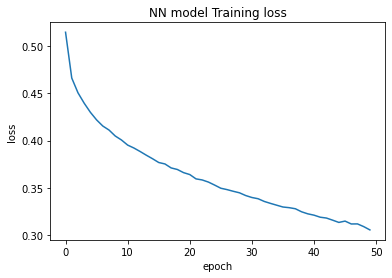

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('NN model Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# save training model
# model.save('NN_64_16.h5')  # creates a HDF5 file 'my_model.h5'
# model.save('NN_32_8.h5')  # creates a HDF5 file 'my_model.h5'
# model.save('NN_32_16.h5')  # creates a HDF5 file 'my_model.h5'
model.save('NN_16.h5')  # creates a HDF5 file 'my_model.h5'

### **Reload the NN models to produce results after sesson reconnect**

In [ ]:
res_NN = pd.DataFrame() # run this only once to initialize df
#Predict output for test data
model_arc = ['NN_16', 'NN_32_8', 'NN_32_16', 'NN_64_16']

for m in model_arc:
    model = load_model(m + '.h5')
    print(model.summary())
    model_df = pd.DataFrame({'ModelID' : [m+':Rouge1', m+':RougeL']})

    y_pred = model.predict(xTest)

    #Return predicted summaries
    idx, doc_index, pred_summaries = predict_summaries(Test_doc_label, y_pred, test_df.text_clean)

    #Convert to binary predictions
    y_pred_bin = (y_pred >=0.5)*1

    #Match with gold summaries
    df_gold = test_df.summary_clean[doc_index]
    gold_summaries = [' '.join(df_gold .iloc[j]) for j in range(len(pred_summaries))]
    summaries_comp = tuple(zip(pred_summaries, gold_summaries))
    scores = rougeScores(pred_summaries, gold_summaries, keys=['rouge1', 'rougeL'], use_stemmer=True)
    #Update sumarry dictionary and save to pickle file
    summaryComp.update({'summaries_comp_'+m: summaries_comp})

    tmp = pd.DataFrame(columns=['recall' , 'precision', 'f1'])
    tmp = tmp.append(pd.DataFrame(scores).T, ignore_index=True)
    tmp = pd.concat([model_df, tmp],axis = 1)
    res_NN = pd.concat([res_NN, tmp], ignore_index=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                24624     
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________________
None
460/460 [==============================] - 1s 1ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                49248     
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                    

In [ ]:
print('Predicted summary by NN model: NN_64_16')
summaries_comp[0][0]

Predicted summary by NN model: NN_64_16


'By MATT SCHWARTZ in Houston and WENDELL JAMIESON in New York Daily News Writers\n\nSaturday, October 14th 1995, 4:22AM\n\nBleeding from a massive chest wound, Tejano star Selena cried, "Help me! Help me! Shaken witnesses yesterday told a spellbound Houston courtroom how the blood-covered, mortally wounded 23-year-old Hispanic singing sensation burst into the lobby of the Corpus Christi Days Inn last March 31.\n\n'

In [ ]:
res_NN

,ModelID,recall,precision,f1
0,NN_16:Rouge1,0.555342,0.746306,0.565705
1,NN_16:RougeL,0.537553,0.718952,0.547235
2,NN_32_8:Rouge1,0.560763,0.729521,0.563156
3,NN_32_8:RougeL,0.541522,0.700605,0.543300
4,NN_32_16:Rouge1,0.557103,0.744142,0.565558
5,NN_32_16:RougeL,0.538271,0.715307,0.545916
6,NN_64_16:Rouge1,0.556960,0.736683,0.565116
7,NN_64_16:RougeL,0.537369,0.706557,0.544387


In [ ]:
summaryComp.keys()

dict_keys(['summaries_comp_T_rank', 'summaries_comp_LR_default', 'summaries_comp_LR_withElasticNet', 'summaries_comp_NN_16', 'summaries_comp_NN_32_8', 'summaries_comp_NN_32_16', 'summaries_comp_NN_64_16'])

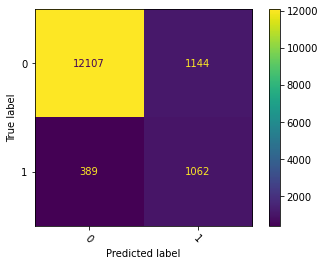

In [ ]:
# Print and visualize the results:
cm = confusion_matrix(yTest, y_pred_bin, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['0','1'])
disp.plot(xticks_rotation=-45)
plt.show()

**Reload results and neccesary varables so far**

In [ ]:
#uncomment following to load train/test data and run rest of the section after sesson disconnect
dataTrain = pd.read_pickle('Data/train_feature.pickle')
train_df, Train_doc_label = dataTrain['train_df'], dataTrain['Train_doc_label']
xTrain, yTrain, domTrain_df = dataTrain['xTrain'], dataTrain['yTrain'], dataTrain['domTrain']

dataTest = pd.read_pickle('Data/test_feature.pickle')
test_df, Test_doc_label = dataTest['test_df'], dataTest['Test_doc_label']
xTest, yTest, domTest_df = dataTest['xTest'], dataTest['yTest'], dataTest['domTest']